## A/B тестирование результатов работы двух моделей

In [2]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
model_a_result = pd.read_csv('../data/lr_pred_target.csv')
model_b_result = pd.read_csv('../data/rf_pred_target.csv')

In [4]:
f1_score(model_a_result['TX_FRAUD'], model_a_result['prediction'], average='macro')

0.5198358413132694

In [5]:
f1_score(model_b_result['TX_FRAUD'], model_b_result['prediction'], average='macro')

0.9124929338609383

In [6]:
def get_bootstrap(data: pd.DataFrame, pred_name: str, target_name: str, metric: object, bootstrap_iterations: int):
    
    np.random.seed(42)

    scores = pd.DataFrame(data={
        "metric": 0.0,
    }, index=range(bootstrap_iterations))

    for i in range(bootstrap_iterations):
        sample = data.sample(frac=1.0, replace=True)
        scores.loc[i, "metric"] = metric(sample[pred_name], sample[target_name])
    return scores

In [7]:
model_a_boot_res = get_bootstrap(model_a_result, 'prediction', 'TX_FRAUD', f1_score, 1000)
model_b_boot_res = get_bootstrap(model_b_result, 'prediction', 'TX_FRAUD', f1_score, 1000)

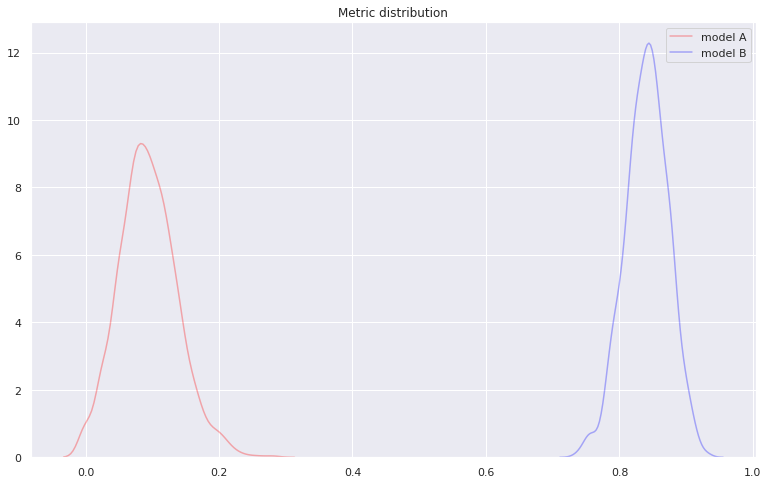

In [8]:
sns.set(rc={'figure.figsize':(13, 8)})

ax = sns.kdeplot(
    data=model_a_boot_res["metric"],
    alpha=0.3,
    color="red",
    label='model A',
)

ax.set(title='Metric distribution')

sns.kdeplot(
    data=model_b_boot_res["metric"],
    alpha=0.3,
    color="blue",
    label='model B',
    ax=ax,
)

In [9]:
model_b_boot_res

,metric
0,0.857143
1,0.845638
2,0.875817
3,0.843537
4,0.812121
...,...
995,0.881890
996,0.878049
997,0.877698
998,0.833333


In [10]:
def commit_ttest(metric_a: pd.Series, metric_b: pd.Series, alpha: float):

    pvalue = ttest_ind(metric_a, metric_b, alternative="less").pvalue

    print(f"pvalue: {pvalue:g}")
    if pvalue < alpha:
        print("Reject null hypothesis.")
    else:
        print("Accept null hypothesis.")

In [11]:
commit_ttest(model_a_boot_res['metric'], model_b_boot_res['metric'], 0.001)

pvalue: 0
Reject null hypothesis.
